In [21]:
import random
import torch
import numpy as np
import pandas as pd

import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix

import sys
import os
sys.path.append(os.path.abspath('..'))
from data.preprocessing import Preprocessor
from src.models import LSTMSeq2One
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
preprocessor = Preprocessor()
zpp4 = preprocessor.zpp4_preprocessing()
spec = preprocessor.spec_preprocessing()

Duplicate rows cleaning: 620it [00:02, 265.50it/s]


In [3]:
zpp4.head(2)

,date,supplier,basis,spec_date,contract_price,estimated_price,contract_price1,estimated_price1,quantity,sum,price_change,id
0,2022-07-02,СОЮЗ ООО Ростов,"Юг Руси, АО",2022-06-15,30.0,30.29,30.0,30.32,27.05,820156.0,1.07,"СОЮЗ ООО Ростов_Юг Руси, АО_2022-06-15"
1,2022-07-02,СОЮЗ ООО Ростов,"Юг Руси, АО",2022-06-15,30.0,30.29,30.0,31.02,28.78,892755.6,3.40,"СОЮЗ ООО Ростов_Юг Руси, АО_2022-06-15"


In [4]:
spec.head(2)

,supplier,supplier_status,item,basis,spec_date,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id
0,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2022-12-19,2022-12-25,По факту,15.0,0.0,25.5,25.0,25.0,40.0,60.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2022-12-19"
1,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2023-01-24,2023-02-12,По факту,15.0,0.0,27.5,27.5,27.5,50.0,59.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2023-01-24"


In [5]:
trash_cols = ['supplier_status', 'item', 'basis',
              'spec_date', 'delivery_period_end', 'payment_terms',
              'logistics', 'consent_price', 'spec_price',
              'volume_contracted', 'bids_submitted']
non_learn_cols = ['supplier', 'id']

In [6]:
def past_agg(df, col, id_col, time_col, select_rows=True, agg='mean'):
    """
    Возвращает аггрегацию по переменной col для каждой группы из id_col,
    выбирая для этого записи, которые были раньше по переменной time_col,
    а также по любым другим условиям из select_rows
    """
    
    if agg == 'mean':
        func = lambda row: df.loc[
            (df[id_col] == row[id_col]) &
            (df[time_col] < row[time_col]) &
            select_rows
        ][col].mean()
    
    elif agg == 'count':
        func = lambda row: len(df.loc[
            (df[id_col] == row[id_col]) &
            (df[time_col] < row[time_col]) &
            select_rows
        ][col])
    
    return df.apply(func, axis=1)

# delivery length features
spec['delivery_length'] = (spec['delivery_period_end'] - spec['spec_date']).map(lambda x: x.days) # продолжительность спецификации
spec['mean_delivery_length'] = past_agg(spec, 'delivery_length', 'supplier', 'spec_date', (spec['bids_contracted'] == 1)) # средняя продолжительность спецификаций поставщика
spec['delivery_length_diff'] = (spec['delivery_length'] - spec['mean_delivery_length']).abs() # разница продолжительности спецификации и средней продолжительности постащика

# volume features
spec['mean_volume'] = past_agg(spec, 'volume_requested', 'supplier', 'spec_date', (spec['bids_contracted'] == 1)) # среднее количество товара поставщика
spec['volume_diff'] = (spec['volume_requested'] - spec['mean_volume']).abs() # разница колисетва товара и среднего количества товара поставщика

spec['conversion'] = past_agg(spec, 'bids_contracted', 'supplier', 'spec_date') # конверсия по предыдущим спецификациям

<Axes: xlabel='bids_contracted', ylabel='conversion'>

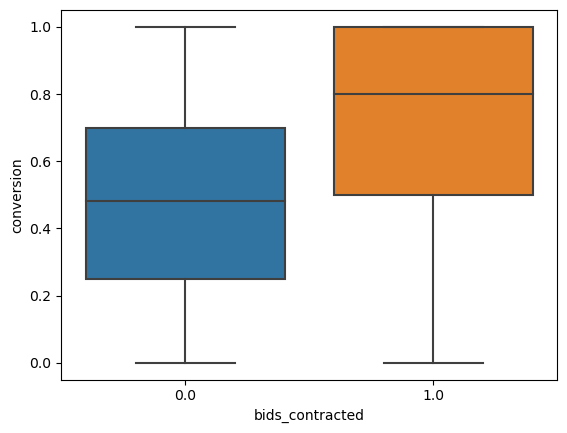

In [7]:
sns.boxplot(x=spec['bids_contracted'], y=spec['conversion'])

<Axes: xlabel='bids_contracted', ylabel='mean_delivery_length'>

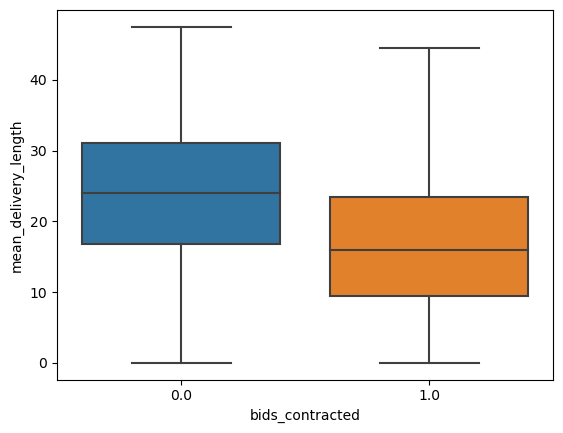

In [8]:
sns.boxplot(x=spec['bids_contracted'], y=spec['mean_delivery_length'], showfliers=False)

<Axes: xlabel='bids_contracted', ylabel='delivery_length_diff'>

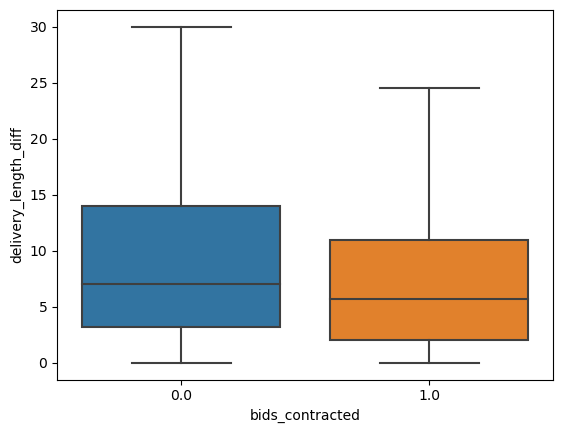

In [9]:
sns.boxplot(x=spec['bids_contracted'], y=spec['delivery_length_diff'].abs(), showfliers=False)

<Axes: xlabel='bids_contracted', ylabel='volume_requested'>

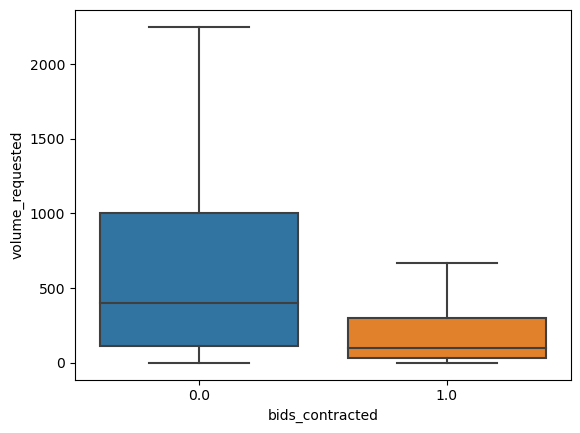

In [10]:
sns.boxplot(x=spec['bids_contracted'], y=spec['volume_requested'], showfliers=False)

<Axes: xlabel='bids_contracted', ylabel='mean_volume'>

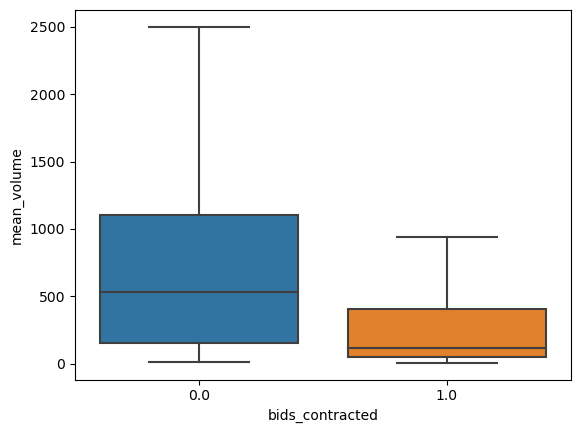

In [11]:
sns.boxplot(x=spec['bids_contracted'], y=spec['mean_volume'], showfliers=False)

<Axes: xlabel='bids_contracted', ylabel='volume_diff'>

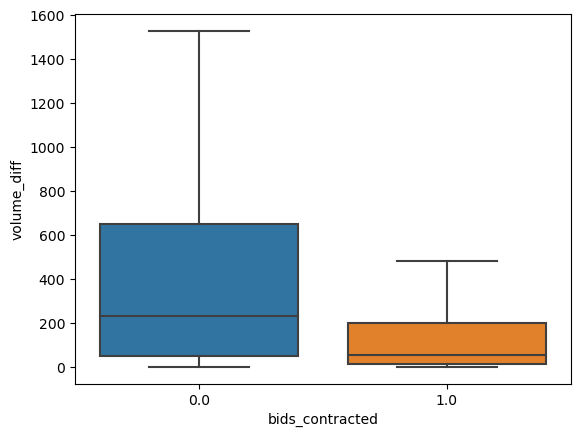

In [12]:
sns.boxplot(x=spec['bids_contracted'], y=spec['volume_diff'].abs(), showfliers=False)

In [7]:
def func(row):
    if row['supplier_status'] == 'СХТП':
        return np.array([1, 0])
    elif row['supplier_status'] == 'Трейдер':
        return np.array([0, 1])
    return np.array([0, 0])

spec[['arg_prod', 'trader']] = np.stack(spec.apply(func, axis=1).values)

<Axes: >

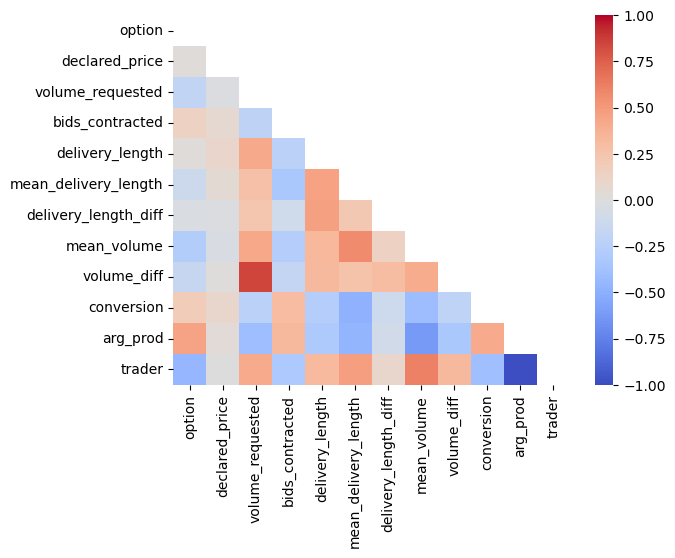

In [8]:
shape_plot = len(spec.columns) - len(trash_cols) - len(non_learn_cols)
mask = np.zeros((shape_plot, shape_plot))
mask[np.triu_indices_from(mask)] = True

sns.heatmap(spec.drop(trash_cols + non_learn_cols, 1).corr(), cmap = 'coolwarm', annot = False, 
            mask=mask,
            vmin=-1, vmax=1)

In [22]:
"""
Разделение набора данных
"""

X_train, X_test, y_train, y_test = train_test_split(
    spec.drop(trash_cols + non_learn_cols + ['bids_contracted'], 1), spec['bids_contracted'],
    test_size=0.33, random_state=42
)

In [23]:
def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

model = CatBoostClassifier(verbose = 0).fit(X_train, y_train)
estimate(model, X_test, y_test)

Accuracy: 0.7346654275092936
ROC AUC: 0.7847445887445887


In [24]:
embed_df = pd.read_csv('../data/final_data/embed_df.csv')
embed_df['date'] = pd.to_datetime(embed_df['date'], format='%Y-%m-%d')
embes_cols = list(embed_df.columns[3:])

In [51]:
spec[embes_cols] = spec.apply(
    lambda row: embed_df.loc[(embed_df['supplier'] == row['supplier']) & (embed_df['date'] < row['spec_date'])][embes_cols].mean(),
    axis=1
)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    spec.drop(trash_cols + non_learn_cols + ['bids_contracted'], 1), spec['bids_contracted'],
    test_size=0.33, random_state=42
)

model = CatBoostClassifier(verbose = 0).fit(X_train, y_train)
estimate(model, X_test, y_test)

Accuracy: 0.7346654275092936
ROC AUC: 0.7847445887445887


In [68]:
"""
Оцениваем ранжирование по каждому дню отдельно
"""

actual = []
predicted = []
days_indexes = spec.loc[y_test.index].groupby('spec_date').apply(lambda x: x.index)

for day in days_indexes:
    actual.append(y_test.loc[day].values)
    predicted.append(model.predict_proba(X_test.loc[day])[:, 1])

def map_(actual, predicted):
    return np.mean([average_precision_score(a,p) for a,p in zip(actual, predicted)])

print(f'Mean average precision: {map_(actual, predicted)}')

Mean average precision: 0.7388713307675892


## Auto Regressive model

In [14]:
spec = spec.sort_values('spec_date').dropna()

In [15]:
spec.head(2)

,supplier,supplier_status,item,basis,spec_date,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id,delivery_length,mean_delivery_length,delivery_length_diff,mean_volume,volume_diff,conversion,arg_prod,trader
3153,ЛЕТО ООО,Трейдер,подсолнечник,"Юг Руси, АО",2022-07-19,2022-07-31,По факту,10.0,0.0,26.0,25.0,0.0,140.0,0.0,1.0,0.0,"ЛЕТО ООО_Юг Руси, АО_2022-07-19",12,16.0,4.0,60.0,80.0,0.500000,0,1
3154,ЛЕТО ООО,Трейдер,подсолнечник,"Юг Руси, АО",2022-07-20,2022-07-31,По факту,10.0,0.0,26.0,25.0,25.0,140.0,155.0,1.0,1.0,"ЛЕТО ООО_Юг Руси, АО_2022-07-20",11,16.0,5.0,60.0,80.0,0.333333,0,1


In [25]:
X = spec.drop(trash_cols + non_learn_cols + ['bids_contracted'], 1).values
y = spec['bids_contracted'].values

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, target_col, time_col, window_size=20):
        self.df = df
        self.target_col = target_col
        self.window_size = window_size

    def __len__(self):
        # Return the number of windows
        return len(self.series) - self.window_size + 1

    def __getitem__(self, idx):
        time = self.df.iloc[idx+self.window_size+1][time_col]
        
        x = self.df.loc[self.df[time_col] < time].iloc[idx:idx+self.window_size].drop(target_col, 1)
        y = self.df.iloc[target_col][idx+self.window_size+1]
        return x, y

In [ ]:
dataset = TimeSeriesDataset(spec, 'bids_contracted', 20)

In [29]:
time = spec.iloc[500+1]['spec_date']

In [30]:
spec.loc[spec['spec_date'] < time]

,supplier,supplier_status,item,basis,spec_date,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id,delivery_length,mean_delivery_length,delivery_length_diff,mean_volume,volume_diff,conversion,arg_prod,trader
3153,ЛЕТО ООО,Трейдер,подсолнечник,"Юг Руси, АО",2022-07-19,2022-07-31,По факту,10.0,0.0,26.0,25.0,0.0,140.00,0.00,1.0,0.0,"ЛЕТО ООО_Юг Руси, АО_2022-07-19",12,16.000000,4.000000,60.000000,80.000000,0.500000,0,1
3154,ЛЕТО ООО,Трейдер,подсолнечник,"Юг Руси, АО",2022-07-20,2022-07-31,По факту,10.0,0.0,26.0,25.0,25.0,140.00,155.00,1.0,1.0,"ЛЕТО ООО_Юг Руси, АО_2022-07-20",11,16.000000,5.000000,60.000000,80.000000,0.333333,0,1
2343,КМЗ ООО,Трейдер,подсолнечник,"ЮР Лабинский МЭЗ ф-л, ООО",2022-07-20,2022-08-07,По факту,10.0,0.0,27.0,26.0,26.0,2000.00,2000.00,1.0,1.0,"КМЗ ООО_ЮР Лабинский МЭЗ ф-л, ООО_2022-07-20",18,16.000000,2.000000,2000.000000,0.000000,1.000000,0,1
4174,Осыченко Е.С. ИП Глава К(Ф)Х,СХТП,подсолнечник,"ЮР Валуйский МЭЗ ф-л, ООО",2022-07-27,2022-08-05,По факту,5.0,0.0,26.0,26.0,26.0,300.00,319.26,1.0,1.0,Осыченко Е.С. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,9,14.000000,5.000000,300.000000,0.000000,0.500000,1,0
2344,КМЗ ООО,Трейдер,подсолнечник,"ЮР Лабинский МЭЗ ф-л, ООО",2022-07-30,2022-08-28,По факту,10.0,0.0,26.0,26.0,0.0,2000.00,0.00,1.0,0.0,"КМЗ ООО_ЮР Лабинский МЭЗ ф-л, ООО_2022-07-30",29,17.000000,12.000000,2000.000000,0.000000,1.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,Жукова Е.В. ИП Глава К(Ф)Х,СХТП,подсолнечник,"Юг Руси, АО",2022-10-16,2022-10-17,По факту,10.0,0.0,22.5,22.0,0.0,21.00,0.00,1.0,0.0,"Жукова Е.В. ИП Глава К(Ф)Х_Юг Руси, АО_2022-10-16",1,13.500000,12.500000,85.500000,64.500000,1.000000,1,0
6062,Чернышев В.В. ИП Глава К(Ф)Х,СХТП,подсолнечник,"Юг Руси, АО",2022-10-16,2022-10-16,По факту,10.0,0.0,22.5,22.0,22.0,20.43,20.43,1.0,1.0,"Чернышев В.В. ИП Глава К(Ф)Х_Юг Руси, АО_2022-...",0,0.000000,0.000000,20.000000,0.430000,1.000000,1,0
1164,Ващаев Н.В. ИП Глава К(Ф)Х,СХТП,подсолнечник,"ЮР Базковский филиал, АО",2022-10-16,2022-10-31,По факту,10.0,0.0,22.0,22.0,22.0,100.00,100.00,1.0,1.0,Ващаев Н.В. ИП Глава К(Ф)Х_ЮР Базковский филиа...,15,24.000000,9.000000,100.000000,0.000000,1.000000,1,0
5172,СТЕПЬ ООО,СХТП,подсолнечник,"ЮР Морозовский филиал, АО",2022-10-16,2022-10-23,По факту,10.0,0.0,22.3,22.0,22.0,1000.00,1000.00,1.0,1.0,"СТЕПЬ ООО_ЮР Морозовский филиал, АО_2022-10-16",7,10.500000,3.500000,1250.000000,250.000000,0.666667,1,0


In [31]:
time

Timestamp('2022-10-17 00:00:00')

In [28]:
AR_model = LSTMSeq2One(11, 9, 1)